# Evaluates our Base Model
I have not implemented a test set yet so this uses the validation set
and just generates some basic stats and pictures 

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from datetime import datetime
import re
import importlib

#visual
import matplotlib.pyplot as plt

# user functions 
import sys
sys.path.append("..")

from modelUtils import loadCheckpoint, plotPredVsTrue, dotDict
from dataUtils import loadEnergyData, processData, energyDataset, getDatasets, normalizeAdjMat
from models.baseSTGCN import STGNN
from evaluation.denormalizedEval import denormalizeLoad

In [4]:
# params
torch.manual_seed(0)
np.random.seed(0)

##### Load our args
config_file = "baseSTGCN_config"
c = importlib.import_module("configs."+config_file)
args = c.args

print(args)

# update args for evaluation purposes
args.save_seq = False
args.load_seq = True
args.seq_path = os.path.join("." + args.seq_path, "testingOnly")


processed_dir = "../data/processed/"

# loss functions to compute
mae_criterion = nn.L1Loss()
mse_criterion = nn.MSELoss()

{'model': 'baseSTGCN', 'historical_input': 24, 'forecast_output': 24, 'subset_feats': ['load', 'node', 'solar_ecmwf'], 'save_seq': False, 'load_seq': True, 'seq_path': './data/processed/nodeSequences', 'processing_function': <function processData at 0x0000025844E3AAE8>, 'device': 'cuda', 'epochs': 200, 'batch_size': 64, 'lr': 0.001, 'steps': 50, 'model_name': 'baselineSTGCN.pth', 'out_feats': 64, 'spatial_feats': 16}


In [5]:
# Get validation data
if args.load_seq:
    # get number of nodes to include
    files = os.listdir(args.seq_path)
    incl_nodes = max([int(re.search("\d{1,5}", f).group(0)) for f in files if re.search("\d", f)])
    _, adj_mat = loadEnergyData(processed_dir, incl_nodes = incl_nodes, partial = False)
else:
    energy_demand, adj_mat = loadEnergyData(processed_dir, incl_nodes = 20, partial = True)

_, val_dataset = getDatasets(args, None, validation_only = True)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# normalized adjacency matrix with self loop
adj_norm = normalizeAdjMat(adj_mat)
adj_norm = adj_norm.to(args['device']) 

val_dataset.inputs.shape, val_dataset.target.shape, adj_norm.shape

C:\Users\ABell\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\ABell\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\ABell\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels
..\dataUtils.py:105: RuntimeWarning: divide by zero encountered in power
  D_norm = D**(-(1/2))


(torch.Size([90, 1487, 24, 2]),
 torch.Size([90, 1487, 23]),
 torch.Size([1487, 1487]))

In [6]:
# Model init
num_nodes = val_dataset.target.shape[1]
num_features = val_dataset.inputs.shape[3]

Gnet = STGNN(num_nodes,
             num_features,
             args.historical_input,
             args.forecast_output-1,
             args).to(device=args.device)

model = loadCheckpoint(Gnet, filename = "baselineSTGCN.pth", folder = '../savedModels')
model

STGNN(
  (block1): spatioTemporalBlock(
    (t1): temporalConv(
      (conv1): Conv2d(2, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv2): Conv2d(2, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv3): Conv2d(2, 64, kernel_size=(1, 3), stride=(1, 1))
    )
    (t2): temporalConv(
      (conv1): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv2): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv3): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
    )
    (batch_norm): BatchNorm2d(1487, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): spatioTemporalBlock(
    (t1): temporalConv(
      (conv1): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
    )
    (t2): temporalConv(
      (conv1): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv2): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1

In [7]:
# Get Predictions
val_predictions = []
val_target = []

mae_list = []
mse_list = []
rmse_list = []

with torch.no_grad():
    Gnet.eval()
    for vbatch_idx, (vfeatures, vmetadata, vtarget) in enumerate(val_loader):
        vfeatures = vfeatures.to(args.device)
        vmetadata = vmetadata.to(args.device)
        vtarget = vtarget.to(args.device)

        # predict 
        vpreds = Gnet(vfeatures, vmetadata, adj_norm)
        mse_loss = mse_criterion(vpreds, vtarget)
        mae_loss = mae_criterion(vpreds, vtarget)
        rmse_loss = torch.sqrt(mse_criterion(vpreds, vtarget))

        # storage and tracking
        mse_list.append(mse_loss.detach().cpu().numpy())
        mae_list.append(mae_loss.detach().cpu().numpy())
        rmse_list.append(rmse_loss.detach().cpu().numpy())
        
        # store preds and target in correct order
        np_vpreds = vpreds.detach().cpu().numpy()
        np_vtarget = vtarget.detach().cpu().numpy()
        val_predictions.append(np_vpreds)
        val_target.append(np_vtarget)
        
val_predictions = np.concatenate(val_predictions)
val_target = np.concatenate(val_target)

mae = np.mean(mae_list)
mse = np.mean(mse_list)
rmse = np.mean(rmse_list)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

torch.Size([32, 1487, 22, 64])
torch.Size([32, 1487, 20, 64])
torch.Size([32, 1487, 18, 64])
torch.Size([32, 1487, 16, 64])
torch.Size([32, 1487, 14, 64])
torch.Size([32, 1487, 22, 64])
torch.Size([32, 1487, 20, 64])
torch.Size([32, 1487, 18, 64])
torch.Size([32, 1487, 16, 64])
torch.Size([32, 1487, 14, 64])
torch.Size([26, 1487, 22, 64])
torch.Size([26, 1487, 20, 64])
torch.Size([26, 1487, 18, 64])
torch.Size([26, 1487, 16, 64])
torch.Size([26, 1487, 14, 64])
Mean Absolute Error: 0.04570917412638664
Mean Squared Error: 0.004516627173870802
Root Mean Squared Error: 0.06699512153863907


In [8]:
val_predictions.shape

(90, 1487, 23)

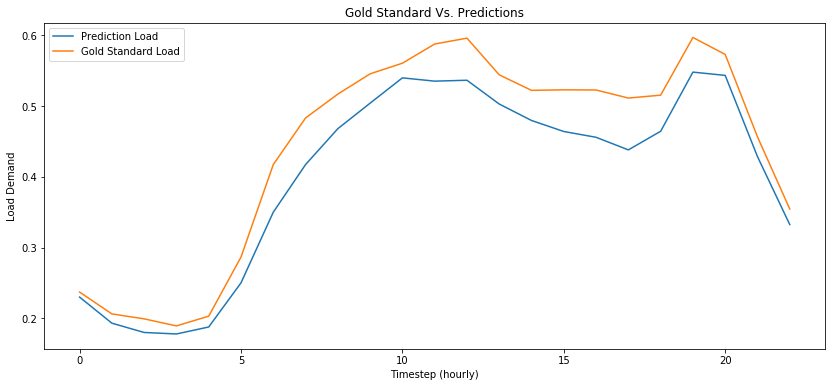

In [9]:
plotPredVsTrue(val_target, val_predictions, 0, 100)

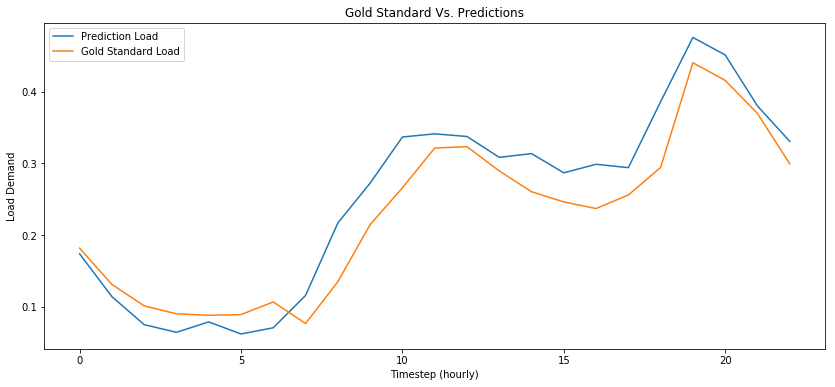

In [10]:
plotPredVsTrue(val_target, val_predictions, 10, 1)

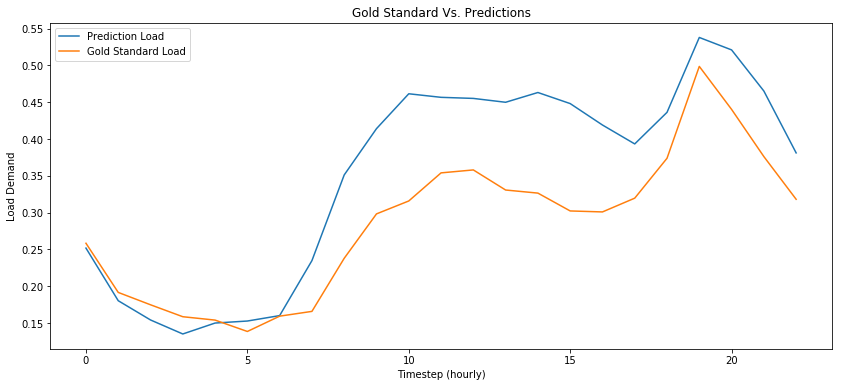

In [11]:
plotPredVsTrue(val_target, val_predictions, 9, 8)

In [12]:
vtarget.shape

torch.Size([26, 1487, 23])

In [13]:
node_min_max = pd.read_csv("../data/processed/Load Min Max Values.csv")
node_min_max

,node,min_load,max_load
0,1,54.4333,130.2554
1,2,344.7395,885.9088
2,3,9.5285,24.5725
3,4,5.8695,14.3730
4,5,52.3974,135.1243
...,...,...,...
1489,1510,35.3623,179.3157
1490,1511,396.8111,2264.5221
1491,1512,4.4061,10.9987
1492,1513,48.7876,154.5291


In [14]:
denorm_preds = denormalizeLoad(val_predictions, node_min_max)
denorm_target = denormalizeLoad(val_target, node_min_max)

mse_criterion(torch.FloatTensor(denorm_preds), torch.FloatTensor(denorm_target)), \
mae_criterion(torch.FloatTensor(denorm_preds), torch.FloatTensor(denorm_target))

(tensor(434.5182), tensor(8.2796))

Same graphs but using denormalized data

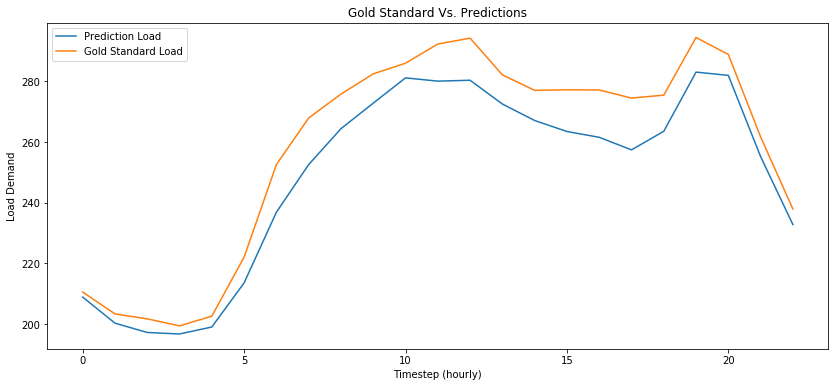

In [15]:
plotPredVsTrue(denorm_target, denorm_preds, 0, 100)

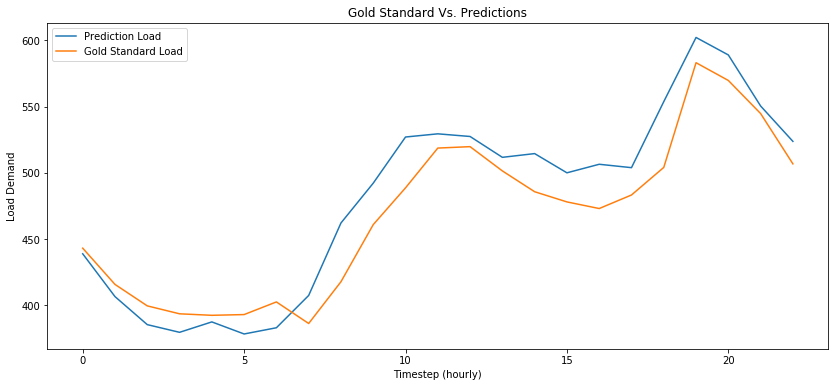

In [16]:
plotPredVsTrue(denorm_target, denorm_preds, 10, 1)

In [18]:
import pickle
with open("./results/TargetValues.pkl", "wb") as f:
    pickle.dump(denorm_target, f)

with open("./results/STGCNPredictions.pkl", "wb") as f:
    pickle.dump(denorm_preds, f)
    
# export normalized 
with open("./results/TargetValues_norm.pkl", "wb") as f:
    pickle.dump(val_target, f)


with open("./results/STGCNPredictions_norm.pkl", "wb") as f:
    pickle.dump(val_predictions, f)

## Visualize time series

In [ ]:
# single node visualized across three time periods
plt.figure(figsize=(14,6))
plt.plot(denorm_target[2][0], label = "Node 1: First Time Period")
plt.plot(denorm_target[15][0], label = "Node 1: Second Time Period")
plt.plot(denorm_target[30][0], label = "Node 1: Third Time Period")
plt.title("Intra-Nodal Variation Across Randomly Selected Time Periods")
plt.xlabel("Timestep (hourly)")
plt.ylabel("Normalized Load Demand")
plt.legend()
plt.show()

In [ ]:
# three different nodes visualized across the same time period
plt.figure(figsize=(14,6))
plt.plot(denorm_target[0][1], label = "Node 1")
plt.plot(denorm_target[0][49], label = "Node 2")
plt.plot(denorm_target[0][99], label = "Node 3")
plt.title("Inter-Nodal Variation Across Randomly Selected Nodes")
plt.xlabel("Timestep (hourly)")
plt.ylabel("Normalized Load Demand")
plt.legend()
plt.show()